In [1]:
%reload_ext autoreload
%autoreload 2

import os
import xarray as xr
import numpy as np

import sys
sys.path.append("..")
import main
import utils
import plot_utils
import matplotlib.pyplot as plt

In [2]:
fold = f"../../results/MHW/CMIP6/"
models = sorted(utils.dirtodict(fold).keys())[1:]
experiments = ['ssp126', 'ssp585']
metrics = ['MHW', 'mean_anomaly']
baselines = ['fixed_baseline', 'moving_baseline']

In [3]:
fold_sat = f"../../results/MHW/satellite/"

results_sst = {
    baseline: {
        metric: {
            kind: 
            xr.open_mfdataset(f'{fold_sat}{baseline}_20_year/*.nc')[f'{metric}{kind}'].mean(['lat', 'lon']).values
             for kind in ['_neg', '', '_pos']
        }
        for metric in metrics
    } for baseline in baselines
}

In [4]:
results = {
    baseline: {
        model: {
            variant: {
                scenario: {metric: [] for metric in metrics}
                for scenario in experiments
            } for variant in sorted(utils.dirtodict(fold+model).keys())[1:]
        } for model in models
    } for baseline in baselines
}


for baseline in baselines:
    for model in models:
        for variant in sorted(utils.dirtodict(fold+model).keys())[1:]:
            for experiment in experiments:
                for metric in metrics:
                    ds = xr.open_dataset(
                        f'../../results/MHW/CMIP6/{model}/{variant}/{baseline}/MHW_metrics_{experiment}.nc')
                    for year in list(ds.time.values):
                        value = np.float32(ds[metric].sel(time=year).mean().values)
                        results[baseline][model][variant][experiment][metric].append(value)


In [5]:
medians = {baseline: {
    scenario: {metric: [] for metric in metrics}
    for scenario in experiments
} for baseline in baselines
}

for baseline in baselines:
    for experiment in experiments:
        for metric in metrics:
            model_ensemble = []
            for model in models:
                variant_ensemble = []
                for variant in sorted(utils.dirtodict(f'../../results/MHW/CMIP6/{model}/').keys())[1:]:
                    variant_ensemble.append(
                        results[baseline][model][variant][experiment][metric][:98])
                variant_median = list(
                    np.median(np.array(variant_ensemble), axis=0))
                model_ensemble.append(variant_median)
            model_median = list(np.median(np.array(model_ensemble), axis=0))
            medians[baseline][experiment][metric] = model_median


In [6]:
pctls = [15, 50, 85]

percentiles = {
    baseline: {
        scenario: {metric: {q: [] for q in pctls} for metric in metrics}
        for scenario in experiments
    }
    for baseline in baselines
}

for baseline in baselines:
    for experiment in experiments:
        for metric in metrics:
            model_ensemble = []
            for model in models:
                variant_ensemble = []
                for variant in sorted(
                    utils.dirtodict(f"../../results/MHW/CMIP6/{model}/").keys()
                )[1:]:
                    variant_ensemble.append(
                        results[baseline][model][variant][experiment][metric][:98]
                    )
                variant_median = list(np.median(np.array(variant_ensemble), axis=0))
                model_ensemble.append(variant_median)
            for p in pctls:
                model_pctl = list(np.percentile(np.array(model_ensemble), p, axis=0))
                percentiles[baseline][experiment][metric][p] = model_pctl

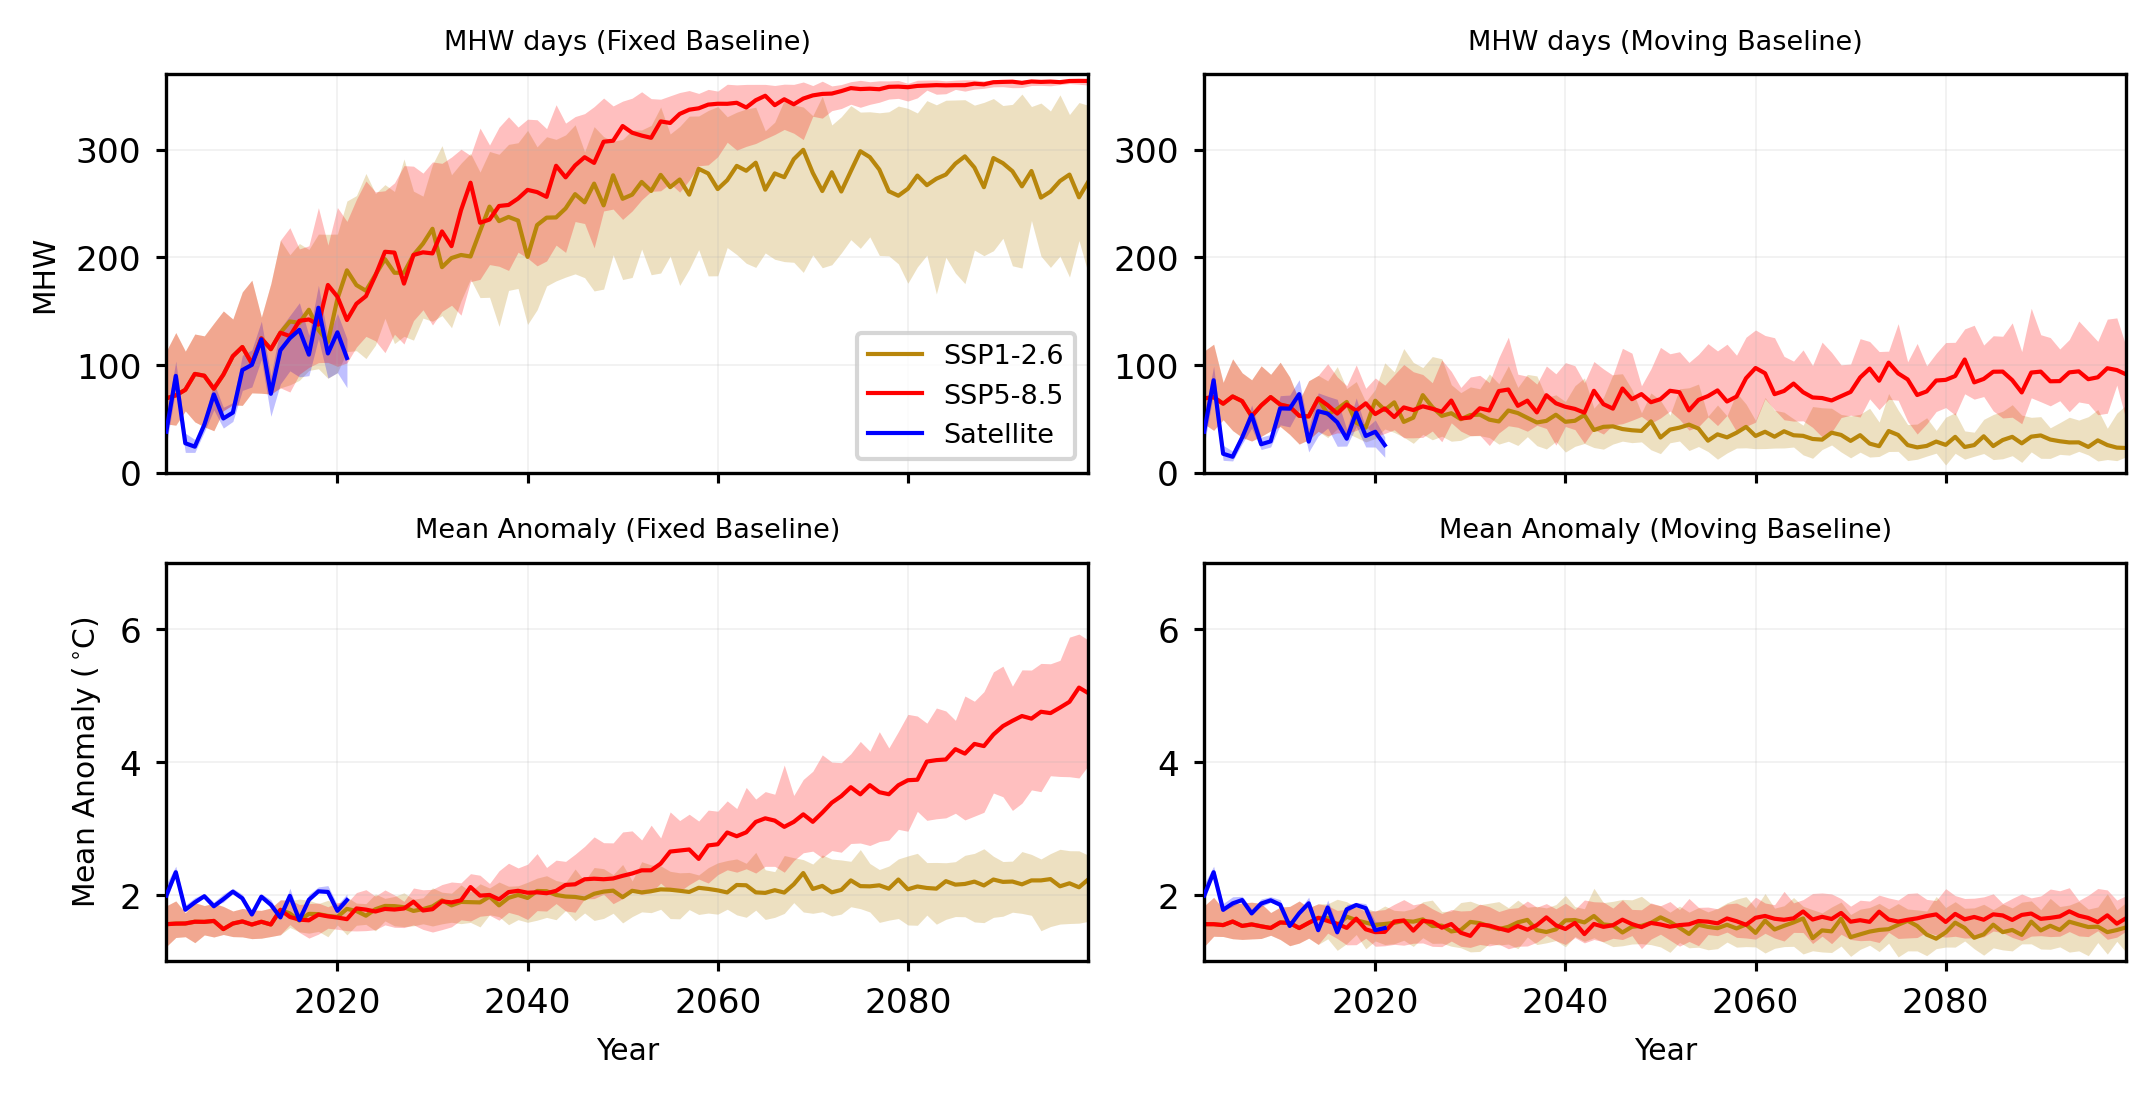

In [7]:
subplots = (2, 2)
fig, ax, fs, text_size = plot_utils.initialize_figure(
    ratio=2, subplots=subplots, fig_size=25, text_size=1.1
)

colors = ["darkgoldenrod", "r", 'b']
alpha = 0.25

def plot(ax, baseline, model, variant, experiment, metric):
    values = results[baseline][model][variant][experiment][metric]
    years = list(range(2002, 2002 + len(values), 1))
    color = colors[1] if experiment == "ssp126" else colors[0]
    ax.plot(
        years,
        values,
        # label=experiment,
        color=color,
        alpha=0.2,
        lw=fs * 0.1,
    )
    ax.set_xlim(2002, 2100)

titles = [['MHW days (Fixed Baseline)', 'MHW days (Moving Baseline)'],
            ['Mean Anomaly (Fixed Baseline)', 'Mean Anomaly (Moving Baseline)']]

scale = 1.3

for k, experiment in enumerate(experiments):
    color = colors[1] if experiment == "ssp126" else colors[0]
    for i, baseline in enumerate(baselines):
        for j, metric in enumerate(["MHW", "mean_anomaly"]):
            ax[j][i].plot(
                range(2002, 2100),
                percentiles[baseline][experiment][metric][50],
                color=colors[k],
                lw=fs * 0.2,
                label="SSP1-2.6" if experiment == "ssp126" else "SSP5-8.5",
            )

            if k == 1:
                ax[j][i].plot(
                    range(2002, 2022),
                    results_sst[baseline][metric][''],
                    color=colors[2],
                    lw=fs * 0.2,
                    label="Satellite",
                    zorder=3,
                )
                ax[j][i].fill_between(
                range(2002, 2022),
                results_sst[baseline][metric]['_neg'],
                results_sst[baseline][metric]['_pos'],
                color=colors[2],
                alpha = alpha,
                lw=0,
            )


            ax[j][i].fill_between(
                range(2002, 2100),
                percentiles[baseline][experiment][metric][pctls[0]],
                percentiles[baseline][experiment][metric][pctls[2]],
                color=colors[k],
                alpha = alpha,
                lw=0,
            )

            ax[i][j].set_xlim(2002, 2099)
            ax[i][j].set_title(titles[i][j], fontsize=1.3*fs)

            if i == 0:
                ax[i][j].set_ylim(0, 370)
                ax[i][j].set_xticklabels([])    
                ax[i][0].set_ylabel("MHW", fontsize=text_size*fs*scale)
            else:
                ax[i][j].set_ylim(1, 7)
                ax[i][j].set_xlabel("Year", fontsize=text_size*fs*scale)
                ax[i][0].set_ylabel("Mean Anomaly ($^\circ$$\!$C)", fontsize=text_size*fs*scale)
                
                
ax[0][0].legend(fontsize=fs * 1.3, loc="lower right")

fig_fold = '../../figures/'
plt.savefig(
    f"{fig_fold}/fig_2.jpeg",
    bbox_inches="tight",
    dpi=300,
)

In [11]:


percentiles[baseline][experiment][metric][50][47]

308.34239196777344

In [40]:
baseline = 'moving_baseline'
metric = 'mean_anomaly'
experiment = 'ssp126'
y=2099

a = []
for model in models:
    res = results[baseline][model]
    aa = []
    for variant in res.keys():
        aa.append(res[variant][experiment][metric][y-2003])
    aa = np.median(aa)
    a.append(aa)

print(np.percentile(a, 10))
print(np.mean(a))
